<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision as tv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Используем размер батча x.size(0)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = LeNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(model, train_loader, device, num_epochs=10, learning_rate=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Вычисление статистики
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Печать статистики после каждой эпохи
        print(f"Эпоха [{epoch+1}/{num_epochs}], Потери: {running_loss/len(train_loader):.4f}, Точность: {100 * correct / total:.2f}%")



In [ ]:
# Подготовка данных MNIST
def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    return train_loader

In [ ]:
# Установка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Получение загрузчика данных
train_loader = get_data_loaders(batch_size=64)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17133488.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 453048.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4137971.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3679128.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train(model, train_loader, device, num_epochs=10, learning_rate=0.001)

Эпоха [1/10], Потери: 1.7263, Точность: 41.45%
Эпоха [2/10], Потери: 0.2836, Точность: 91.53%
Эпоха [3/10], Потери: 0.1634, Точность: 95.03%
Эпоха [4/10], Потери: 0.1179, Точность: 96.40%
Эпоха [5/10], Потери: 0.0944, Точность: 97.09%
Эпоха [6/10], Потери: 0.0811, Точность: 97.48%
Эпоха [7/10], Потери: 0.0710, Точность: 97.79%
Эпоха [8/10], Потери: 0.0640, Точность: 98.03%
Эпоха [9/10], Потери: 0.0584, Точность: 98.23%
Эпоха [10/10], Потери: 0.0537, Точность: 98.33%


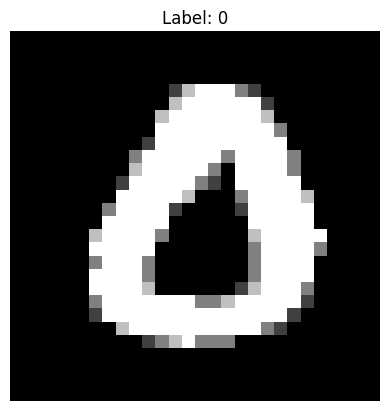

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Загрузить одно изображение из MNIST
def show_image(image, label):
    image_np = image.squeeze().cpu().numpy()
    plt.imshow(image_np, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Получить одно изображение и метку
images, labels = next(iter(train_loader))
image, label = images[0], labels[0]

# Показать изображение
show_image(image, label.item())


In [ ]:
# Генерация adversarial примера с использованием FGSM
def fgsm_attack(model, image, true_label, epsilon, target_label):
    model.eval()

    # Убедимся, что image и true_label на одном устройстве (CPU или GPU)
    image = image.unsqueeze(0).to(device)  # Добавляем размер батча
    true_label = torch.tensor([true_label]).to(device)  # Добавляем размер батча

    # Создаем новый тензор, который будет являться leaf-тензором и поддерживает градиенты
    image = torch.autograd.Variable(image, requires_grad=True)

    # Прямой проход
    output = model(image)
    loss = F.cross_entropy(output, true_label)

    # Обратный проход
    model.zero_grad()
    loss.backward()

    # Генерация шума
    perturbation = epsilon * image.grad.sign()

    # Создание adversarial примера
    adv_image = image + perturbation
    adv_image = torch.clamp(adv_image, 0, 1)  # Обрезка значений пикселей

    return adv_image.squeeze(0)  # Удаление размерности батча

In [ ]:
# Задаем параметры
epsilon = 0.1  # Амплитуда шума
target_label = (label.item() + 1) % 10  # Целевой класс для атаки

In [ ]:
# Генерация adversarial примера
adversarial_image = fgsm_attack(model, image, label.item(), epsilon, target_label)

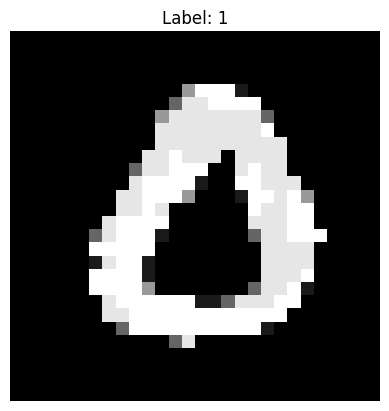

In [ ]:
# Показать adversarial изображение
show_image(adversarial_image.cpu().detach(), target_label)

In [ ]:
# Проверка метки adversarial примера
with torch.no_grad():
    output = model(adversarial_image.unsqueeze(0).to(device))  # Добавляем размер батча
    _, predicted = torch.max(output, 1)
    print(f"Predicted Label for Adversarial Image: {predicted.item()}")

Predicted Label for Adversarial Image: 0
